In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from google.colab import files
import os, shutil, pathlib

In [2]:
# Upload Kaggle API to download dataset
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soham0017","key":"0c2a94d5bb63ff3b27bc6288d658ce40"}'}

In [3]:
!mkdir ~/.kaggle # create a ~/.kaggle folder
!cp kaggle.json ~/.kaggle/ # copy the key file to it
!chmod 600 ~/.kaggle/kaggle.json # file is only readable by current user, yourself

!kaggle competitions download -c dogs-vs-cats

 99% 808M/812M [00:22<00:00, 40.4MB/s]
100% 812M/812M [00:22<00:00, 38.4MB/s]


In [4]:
# uncompressing it quietly
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

In [6]:
# copying images to training, validation, and test directories

original_dir = pathlib.Path("train") # path to directory with original dataset
new_base_dir = pathlib.Path("cats_vs_dogs_small") # directory where we will store our smaller dataset

"""
we will use smaller dataset (train size = 1000) because in real world problem, we
might not get dataset of this size(25000)
"""


'\nwe will use smaller dataset (train size = 1000) because in real world problem, we\nmight not get dataset of this size(25000)\n'

In [7]:
def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src = original_dir / fname, dst = dir / fname)

make_subset("train", start_index = 0, end_index = 1000)
make_subset("validation", start_index = 1000, end_index = 1500)
make_subset("test", start_index = 1500, end_index = 2500)

In [8]:
# Data preprocessing {
    # reading pictures
    # dcode jpeg content to rgb grid of pixels
    # convert these to floating-point tensors
    # resize them
    # pack them into batches } all this using ... image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train", image_size = (180, 180), batch_size = 32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation", image_size = (180, 180), batch_size = 32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test", image_size = (180, 180), batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [9]:
# output of one of these dataset objects
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape )
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [10]:
# Data Augmentation : with small datset chances of overfitting are high therefore...
data_augmentation = keras.Sequential(
     [
         layers.RandomFlip("horizontal"),
         layers.RandomRotation(0.1),
         layers.RandomZoom(0.2),
     ]
 )

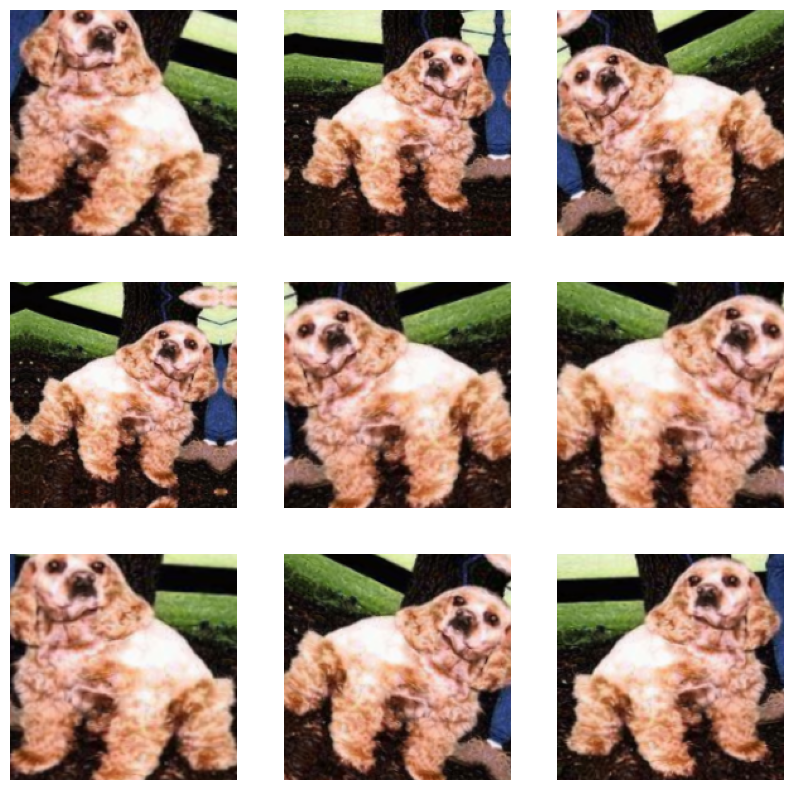

In [11]:
plt.figure(figsize = (10,10))
for images, _ in train_dataset.take(14):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[30].numpy().astype("uint8"))
    plt.axis("off")

In [12]:
# Building the model

inputs = keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./ 255)(x)
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPool2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPool2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPool2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPool2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)

model = keras.Model(inputs = inputs, outputs = outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

In [14]:
model.compile(loss = "binary_crossentropy", optimizer = "rmsprop", metrics=["accuracy"])

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet_from_scratch_with_augmentation.keras",
        save_best_only = True,
        monitor = "val_loss")
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/100
63/63 [==============================] - 15s 88ms/step - loss: 0.7016 - accuracy: 0.4925 - val_loss: 0.6919 - val_accuracy: 0.5120
Epoch 2/100
63/63 [==============================] - 5s 72ms/step - loss: 0.7030 - accuracy: 0.5190 - val_loss: 0.6899 - val_accuracy: 0.5020
Epoch 3/100
63/63 [==============================] - 7s 106ms/step - loss: 0.6913 - accuracy: 0.5545 - val_loss: 0.6649 - val_accuracy: 0.5970
Epoch 4/100
63/63 [==============================] - 4s 65ms/step - loss: 0.7102 - accuracy: 0.5855 - val_loss: 0.6454 - val_accuracy: 0.6290
Epoch 5/100
63/63 [==============================] - 4s 61ms/step - loss: 0.6373 - accuracy: 0.6195 - val_loss: 1.2189 - val_accuracy: 0.5170
Epoch 6/100
63/63 [==============================] - 6s 98ms/step - loss: 0.6421 - accuracy: 0.6390 - val_loss: 0.6341 - val_accuracy: 0.6050
Epoch 7/100
63/63 [==============================] - 5s 80ms/step - loss: 0.6188 - accuracy: 0.6475 - val_loss: 0.6229 - val_accuracy: 0.6380
Epoc

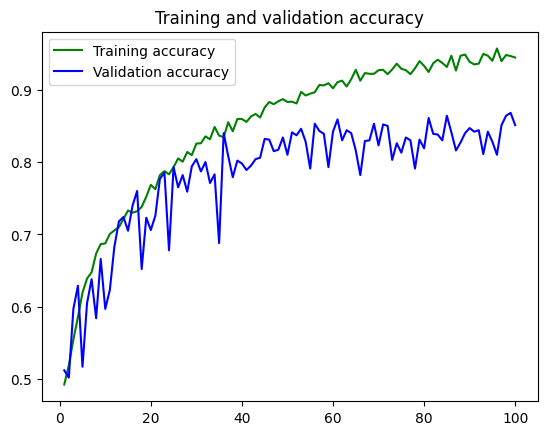

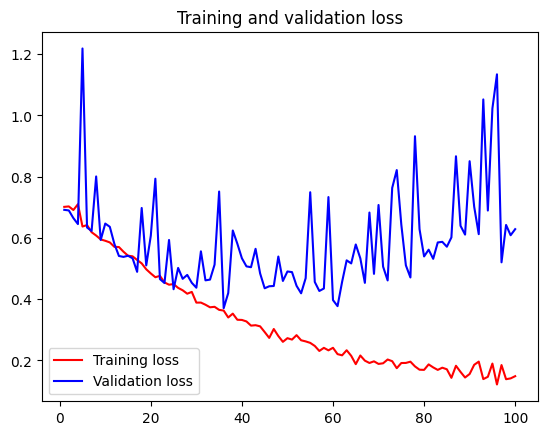

In [16]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "g", label = "Training accuracy")
plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [18]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras"
)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy:{test_acc:.3f}")

63/63 [==============================] - 2s 32ms/step - loss: 0.4164 - accuracy: 0.8225
Test accuracy:0.822
